In [ ]:
# Installing torch_nightly and fastai 
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html  gwpy &> /dev/null
!pip install fastai  gwpy &> /dev/null
!pip install matplotlib==3.1.1

^C
     |████████████████████████████████| 13.1 MB 32.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# import libraries

from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks")
os.mkdir("Test Label Classification Data")
os.chdir("./Test Label Classification Data")

In [ ]:
df1 = pd.read_json('test.json')

In [ ]:
df1.head()

,description,title,content,labels
0,Another new release of Git is here! Take a loo...,Highlights from Git 2.36,"<div class=""page"" id=""readability-page-1""><div...",git
1,C# async and await keywords simplify a lot asy...,C# async await explained - NDepend,"<div class=""page"" id=""readability-page-1""><div...",csharp
2,Discussed in #5496 Originally posted by MadsTo...,[Proposal]: Roles and extensions · Issue #5497...,"<div class=""page"" id=""readability-page-1""><div...",csharp
3,"In this post, we'll build a one-line WebAssemb...",A One Line Microservice with Spin,"<div class=""page"" id=""readability-page-1""><art...",wasm
4,"In the previous post, we saw that with nullabl...",Maarten Balliauw {blog},"<div class=""page"" id=""readability-page-1""><div...",csharp


In [ ]:
df1.drop(columns=['description', 'title'], inplace=True)
df1.head()

,content,labels
0,"<div class=""page"" id=""readability-page-1""><div...",git
1,"<div class=""page"" id=""readability-page-1""><div...",csharp
2,"<div class=""page"" id=""readability-page-1""><div...",csharp
3,"<div class=""page"" id=""readability-page-1""><art...",wasm
4,"<div class=""page"" id=""readability-page-1""><div...",csharp


In [ ]:
df1['labels'].value_counts()

leadership    10
dotnet         8
wasm           6
csharp         5
docker         5
github         4
Azure          3
git            2
Name: labels, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['labels'], test_size = 0.3)

In [ ]:
df_trn.head()

,content,labels
39,"<div id=""readability-content""><div class=""page...",Azure
26,"<div class=""page"" id=""readability-page-1""><div...",docker
30,"<div class=""page"" id=""readability-page-1""><div...",wasm
5,"<div class=""page"" id=""readability-page-1""><sec...",wasm
8,"<div class=""page"" id=""readability-page-1""><sec...",csharp


In [ ]:
df_val.head()

,content,labels
37,"<DIV class=""page"" id=""readability-page-1""><div...",leadership
33,"<div id=""readability-content""><div class=""page...",dotnet
6,"<div id=""readability-content""><div class=""page...",git
25,"<div class=""page"" id=""readability-page-1""><div...",docker
4,"<div class=""page"" id=""readability-page-1""><div...",csharp


In [ ]:
df_trn.shape, df_val.shape

((30, 2), (13, 2))

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm.show_batch()

idx,text
0,wasm xxbos csharp xxbos dotnet xxbos dotnet xxbos dotnet xxbos leadership xxbos csharp xxbos dotnet xxbos xxmaj azure xxbos docker xxbos docker xxbos dotnet xxbos wasm xxbos leadership xxbos xxunk xxbos csharp xxbos dotnet xxbos leadership xxbos leadership xxbos github xxbos leadership xxbos github xxbos wasm xxbos leadership xxbos leadership xxbos csharp xxbos github xxbos xxmaj azure xxbos docker xxbos wasm xxbos wasm xxbos csharp xxbos dotnet xxbos dotnet xxbos
1,wasm xxbos csharp xxbos dotnet xxbos dotnet xxbos dotnet xxbos leadership xxbos csharp xxbos dotnet xxbos xxmaj azure xxbos docker xxbos docker xxbos dotnet xxbos wasm xxbos leadership xxbos xxunk xxbos csharp xxbos dotnet xxbos leadership xxbos leadership xxbos github xxbos leadership xxbos github xxbos wasm xxbos leadership xxbos leadership xxbos csharp xxbos github xxbos xxmaj azure xxbos docker xxbos wasm xxbos wasm xxbos csharp xxbos dotnet xxbos dotnet xxbos
2,xxbos csharp xxbos dotnet xxbos dotnet xxbos dotnet xxbos leadership xxbos csharp xxbos dotnet xxbos xxmaj azure xxbos docker xxbos docker xxbos dotnet xxbos wasm xxbos leadership xxbos xxunk xxbos csharp xxbos dotnet xxbos leadership xxbos leadership xxbos github xxbos leadership xxbos github xxbos wasm xxbos leadership xxbos leadership xxbos csharp xxbos github xxbos xxmaj azure xxbos docker xxbos wasm xxbos wasm xxbos csharp xxbos dotnet xxbos dotnet xxbos dotnet
3,csharp xxbos dotnet xxbos dotnet xxbos dotnet xxbos leadership xxbos csharp xxbos dotnet xxbos xxmaj azure xxbos docker xxbos docker xxbos dotnet xxbos wasm xxbos leadership xxbos xxunk xxbos csharp xxbos dotnet xxbos leadership xxbos leadership xxbos github xxbos leadership xxbos github xxbos wasm xxbos leadership xxbos leadership xxbos csharp xxbos github xxbos xxmaj azure xxbos docker xxbos wasm xxbos wasm xxbos csharp xxbos dotnet xxbos dotnet xxbos dotnet xxbos
4,xxbos dotnet xxbos dotnet xxbos dotnet xxbos leadership xxbos csharp xxbos dotnet xxbos xxmaj azure xxbos docker xxbos docker xxbos dotnet xxbos wasm xxbos leadership xxbos xxunk xxbos csharp xxbos dotnet xxbos leadership xxbos leadership xxbos github xxbos leadership xxbos github xxbos wasm xxbos leadership xxbos leadership xxbos csharp xxbos github xxbos xxmaj azure xxbos docker xxbos wasm xxbos wasm xxbos csharp xxbos dotnet xxbos dotnet xxbos dotnet xxbos leadership


In [ ]:
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 3.31E-01


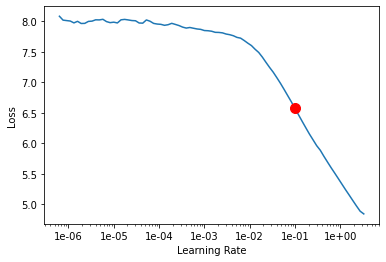

In [ ]:
lang_mod.lr_find()
lang_mod.recorder.plot(suggestion=True)

In [ ]:
lang_mod.fit_one_cycle(4, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,7.286512,7.215660,0.067857,00:00
1,7.655976,6.369601,0.095089,00:00
2,7.380193,5.322730,0.109821,00:00
3,7.332755,5.117670,0.122098,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.31E-01


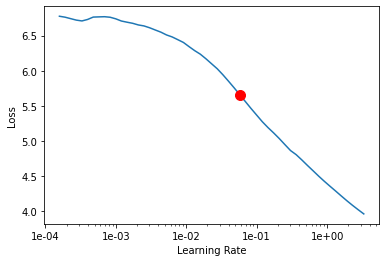

In [ ]:
lang_mod.freeze_to(-1)
lang_mod.lr_find()
lang_mod.recorder.plot(skip_start=40, suggestion=True)

In [ ]:
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,6.420667,5.041970,0.111607,00:00
1,6.717023,4.524006,0.295536,00:00
2,6.629361,4.270892,0.370982,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 2.75E-01


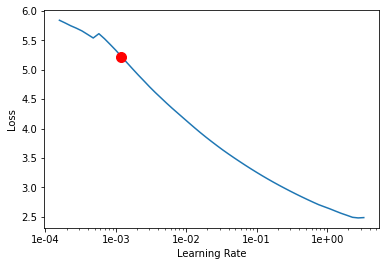

In [ ]:
lang_mod.freeze_to(-2)
lang_mod.lr_find()
lang_mod.recorder.plot(skip_start=40, suggestion=True)

In [ ]:
lang_mod.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.804391,2.055211,0.562500,00:00
1,2.826040,1.986561,0.566295,00:00
2,2.816873,1.933292,0.565179,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 1.74E-02


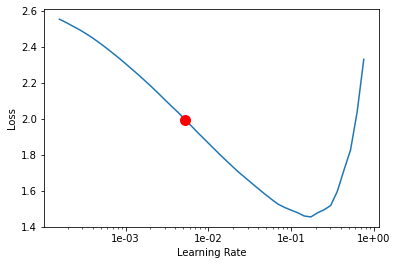

In [ ]:
lang_mod.unfreeze()
lang_mod.lr_find()
lang_mod.recorder.plot(skip_start=40, suggestion=True)

In [ ]:
lang_mod.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,5.521674,4.156384,0.381250,00:00
1,5.560616,3.956094,0.432589,00:00
2,5.564578,3.886301,0.467411,00:00


In [ ]:
lang_mod.save_encoder('my_okayish_encoder')

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=30)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
<DIV class="page" id="readability-page-1"><div><article><header><h3><span>Microsoft is giving employees the ultimate form of appreciation--a bigger paycheck.</span></h3></header><article><figure><picture><source media="(max-width:600px)" srcset="https://proxy-prod.omnivore-image-cache.app/0x0,swD_tg0AXh3sZY62hOhrPhe04XJuAdt1ZVhjbIRH4Ddw/https://img-cdn.inc.com/image/upload/w_970,h_450,c_fill/images/panoramic/getty_459885938_t0lfbn.jpg,"><source media="(min-width:601px)" srcset="https://proxy-prod.omnivore-image-cache.app/0x0,sKojI9H9dTJWzAJIECBuGy9r7XAeJRZ239UAbLQo5vc8/https://img-cdn.inc.com/image/upload/w_1920,h_1080,c_fill/images/panoramic/getty_459885938_t0lfbn.jpg,"><img src="https://proxy-prod.omnivore-image-cache.app/0x0,sKojI9H9dTJWzAJIECBuGy9r7XAeJRZ239UA

In [ ]:
data_clas.show_batch()

In [ ]:
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
learn_classifier.load_encoder('my_okayish_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (30 items)
x: TextList
xxbos xxmaj azure,xxbos docker,xxbos wasm,xxbos wasm,xxbos csharp
y: CategoryList
<div id="readability-content"><div class="page" id="readability-page-1"><div><article><p>Posted on <time>Tuesday, Oct 12, 2021</time></p><section data-swiftype-index="true"><p>Containers have emerged as one of the de facto standards for running software. When adopted with the right mindset, they can drastically improve the development lifecycle and help to close the loop between local development and running your applications in the cloud.</p><p>If you’re at the stage of trying to run your application in Microsoft Azure, the choices can be overwhelming. The Azure Container <a href="https://azure.microsoft.com/en-gb/product-categories/containers/">product page</a> lists 7 different products on their landing page, and for new users it can often be difficult to decide which of the myriad products is right for their use case. What can

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 4.37E-02


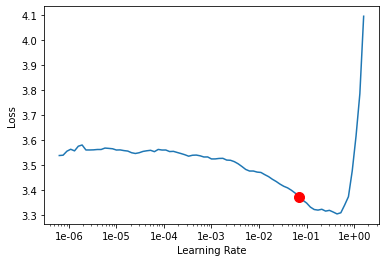

In [ ]:
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

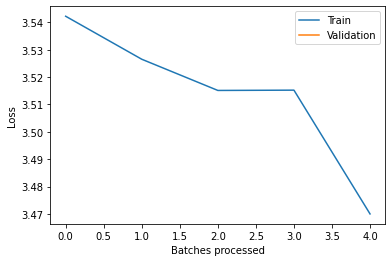

In [ ]:
learn_classifier.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 2.51E-02


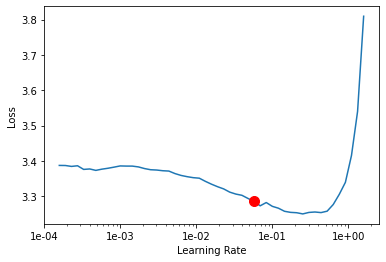

In [ ]:
learn_classifier.freeze_to(-1)
learn_classifier.lr_find()
learn_classifier.recorder.plot(skip_start=40, suggestion=True)

In [ ]:
learn_classifier.show_results()

IndexError: ignored

In [ ]:
learn_classifier.predict('35 people evacuated after fire breaks out at Jalan Bukit Merah flat')

(Category tensor(4),
 tensor(4),
 tensor([0.0312, 0.0285, 0.0363, 0.0349, 0.0394, 0.0317, 0.0290, 0.0379, 0.0264,
         0.0328, 0.0334, 0.0303, 0.0381, 0.0375, 0.0312, 0.0306, 0.0284, 0.0356,
         0.0390, 0.0375, 0.0293, 0.0358, 0.0314, 0.0310, 0.0332, 0.0311, 0.0380,
         0.0299, 0.0337, 0.0370]))

In [ ]:
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([600, 19])